# Clustering 
The objective of this part is to extract relevant statistics and spatial features within a defined radius around each Airbnb location and merge these features into a unified dataset. The key steps involved are:
## Datasets Overview
1. **Points of Interest (POI):**
   - Contains information about various facilities such as schools, cultural centers, recreational areas, and more.
2. **Airbnb Listings:**
   - Geolocated data with multiple entries per listing due to changes in reviews, ratings, and prices over time.
3. **NYPD 2024 Crime Data:**
   - Crime incidents categorized into felonies, misdemeanors, and violations.
4. **Shooting Statistics:**
   - Data on shooting incidents, including counts of shootings and murders.
## Processing and Feature Extraction
1. **Airbnb Data Cleaning:**
   - Retain only the latest record for each Airbnb ID to ensure uniqueness.
   - Aggregate review scores and prices for each listing.

2. **Buffer Creation:**
   - Generate buffer zones (e.g., 3000 meters) around each Airbnb location to define the area of interest for feature aggregation.

3. **Spatial Joins and Aggregations:**
   - **Crime Data:** Aggregate the counts of felonies, misdemeanors, and violations within the buffer.
   - **Shooting Data:** Count the total number of shootings and murders within the buffer.
   - **Points of Interest:** Calculate the number of nearby facilities for categories such as schools, cultural centers, and recreational areas.

4. **Final Merging:**
   - Combine all aggregated features from the datasets into a single unified dataframe.
   - Ensure each Airbnb listing is enriched with:
     - Crime statistics.
     - Shooting statistics.
     - Counts of nearby points of interest.
## Output
- The final enriched dataset is saved as a CSV file for further analysis or predictive modeling.
## Purpose
The resulting dataset provides a geospatially enriched feature set for Airbnb listings, enabling advanced spatial analysis, predictive modeling, or data-driven decision-making.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import geopandas as gpd
from shapely.geometry import Point
from shapely.wkt  import loads

## Loading the data

In [ ]:
poi_df = pd.read_csv('../../exports/POI.csv')
#income_df = pd.read_csv('../../exports/Income.csv')
airbnb_df = pd.read_csv('../../exports/airbnb_data_processed.csv')
complaint_df = pd.read_csv('../../exports/NYPD_Complaint_Data_Current__Year_To_Date__20241223_preprocessed.csv')
shooting_df = pd.read_csv('../../exports/shootings_preprocessed.csv')
airbnb_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187559 entries, 0 to 187558
Data columns (total 17 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Unnamed: 0                    187559 non-null  int64  
 1   id                            187559 non-null  int64  
 2   host_id                       187559 non-null  int64  
 3   host_listings_count           187558 non-null  float64
 4   neighbourhood_cleansed        187559 non-null  object 
 5   neighbourhood_group_cleansed  187559 non-null  object 
 6   latitude                      187559 non-null  float64
 7   longitude                     187559 non-null  float64
 8   property_type                 187559 non-null  object 
 9   room_type                     187559 non-null  object 
 10  accommodates                  187559 non-null  int64  
 11  bathrooms                     187559 non-null  int64  
 12  bedrooms                      187559 non-nul

## Airbnb Data

In [3]:
# airbnb_df = airbnb_df[['id','latitude', 'longitude', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'number_of_reviews', 'review_scores_rating']].copy()
airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187559 entries, 0 to 187558
Data columns (total 17 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Unnamed: 0                    187559 non-null  int64  
 1   id                            187559 non-null  int64  
 2   host_id                       187559 non-null  int64  
 3   host_listings_count           187558 non-null  float64
 4   neighbourhood_cleansed        187559 non-null  object 
 5   neighbourhood_group_cleansed  187559 non-null  object 
 6   latitude                      187559 non-null  float64
 7   longitude                     187559 non-null  float64
 8   property_type                 187559 non-null  object 
 9   room_type                     187559 non-null  object 
 10  accommodates                  187559 non-null  int64  
 11  bathrooms                     187559 non-null  int64  
 12  bedrooms                      187559 non-nul

The Airbnb dataset contains multiple entries for some IDs because the review count, rating, and price change over time. For our final model, it is crucial to ensure that we do not include duplicate Airbnb data, as this could introduce bias. To ensure unique IDs in the final dataset, we retain only the latest entry based on the maximum review count. Additionally, we calculate the mean review score and the mean price for each ID.

In [28]:

uniqueID_airbnb = airbnb_df.groupby('id', as_index=False).agg({
    'room_type': 'first',              # Take the first room_type value
    'accommodates': 'first',          # Take the first accommodates value
    'bathrooms': 'first',             # Take the first bathrooms value
    'bedrooms': 'first',              # Take the first bedrooms value
    'beds': 'first',                  # Take the first beds value
    'price': 'mean',                  # Take the average price
    'number_of_reviews': 'max',       # Take the maximum number_of_reviews
    'review_scores_rating': 'mean',   # Take the average review_scores_rating
    'latitude': 'first',              # Keep the first geometry value              
    'longitude': 'first',              # Keep the first geometry value              
})


uniqueID_airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26270 entries, 0 to 26269
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    26270 non-null  int64  
 1   room_type             26270 non-null  object 
 2   accommodates          26270 non-null  int64  
 3   bathrooms             26270 non-null  int64  
 4   bedrooms              26270 non-null  float64
 5   beds                  26270 non-null  float64
 6   price                 26270 non-null  float64
 7   number_of_reviews     26270 non-null  int64  
 8   review_scores_rating  26270 non-null  float64
 9   latitude              26270 non-null  float64
 10  longitude             26270 non-null  float64
dtypes: float64(6), int64(4), object(1)
memory usage: 2.2+ MB


In the end, we obtain a unique Airbnb dataset containing **26,270** entries.

## Crime Data

In [5]:
complaint_df.head()

,Unnamed: 0,CMPLNT_FR_DT,CRM_ATPT_CPTD_CD,LAW_CAT_CD,OFNS_DESC,PD_DESC,Latitude,Longitude,Lat_Lon,New Georeferenced Column
0,0,2024-07-02,COMPLETED,FELONY,SEX CRIMES,SODOMY 3,40.887314,-73.847272,"(40.8873136344706, -73.8472717577564)",POINT (-73.8472717577564 40.8873136344706)
1,2,2024-03-08,COMPLETED,VIOLATION,HARRASSMENT 2,"HARASSMENT,SUBD 3,4,5",40.559481,-74.178539,"(40.559481, -74.178539)",POINT (-74.178539 40.559481)
2,3,2024-04-04,COMPLETED,FELONY,ROBBERY,"ROBBERY,BEGIN AS SHOPLIFTING",40.634036,-74.123607,"(40.634036, -74.123607)",POINT (-74.123607 40.634036)
3,4,2024-06-05,COMPLETED,MISDEMEANOR,ASSAULT 3 & RELATED OFFENSES,ASSAULT 3,40.536852,-74.213994,"(40.536852, -74.213994)",POINT (-74.213994 40.536852)
4,5,2024-08-09,COMPLETED,FELONY,GRAND LARCENY,"LARCENY,GRAND BY FALSE PROMISE-NOT IN PERSON C...",40.542560,-74.216738,"(40.54256, -74.216738)",POINT (-74.216738 40.54256)


In [6]:
complaint_df['LAW_CAT_CD'].unique()

array(['FELONY', 'VIOLATION', 'MISDEMEANOR'], dtype=object)

We use only the "Law Category" as a feature because "ofns_Desc" is likely to have a high correlation with the "Law Category" and would unnecessarily increase the feature dimensions. To keep it simple, we focus solely on the "Law Category."

In [7]:

complaint_df = complaint_df[['LAW_CAT_CD', 'New Georeferenced Column']]
complaint_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431793 entries, 0 to 431792
Data columns (total 2 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   LAW_CAT_CD                431793 non-null  object
 1   New Georeferenced Column  431793 non-null  object
dtypes: object(2)
memory usage: 6.6+ MB


## Shooting Data

In [8]:
shooting_df.head()

,Unnamed: 0,occur_date,statistical_murder_flag,latitude,longitude,geocoded_column
0,1,2024-07-06,N,40.599224,-73.764932,POINT (-73.764932 40.599224)
1,4,2024-06-28,N,40.735693,-73.814705,POINT (-73.814705 40.735693)
2,5,2024-09-02,Y,40.671008,-73.959655,POINT (-73.959655 40.671008)
3,6,2024-06-29,N,40.828466,-73.918981,POINT (-73.918981 40.828466)
4,7,2024-07-12,Y,40.726054,-73.983534,POINT (-73.98353371783699 40.726053914581264)


In [9]:
shooting_df = shooting_df[['statistical_murder_flag', 'geocoded_column']]
shooting_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   statistical_murder_flag  881 non-null    object
 1   geocoded_column          881 non-null    object
dtypes: object(2)
memory usage: 13.9+ KB


## Geospatial Data 
To showcase the use of geospatial data, we visualize a map of New York City (NYC) with its **community districts** divided by **boroughs**. This provides an overview of how the data is distributed geographically.

In [10]:
districts_gdf = gpd.read_file('../../geo/Community Districts.geojson')

In [ ]:
boro_cd_to_borough = {
    '1': 'Manhattan',
    '2': 'Bronx',
    '3': 'Brooklyn',
    '4': 'Queens',
    '5': 'Staten Island'
}

districts_gdf['BOROUGH'] = districts_gdf['boro_cd'].str[0].map(boro_cd_to_borough)

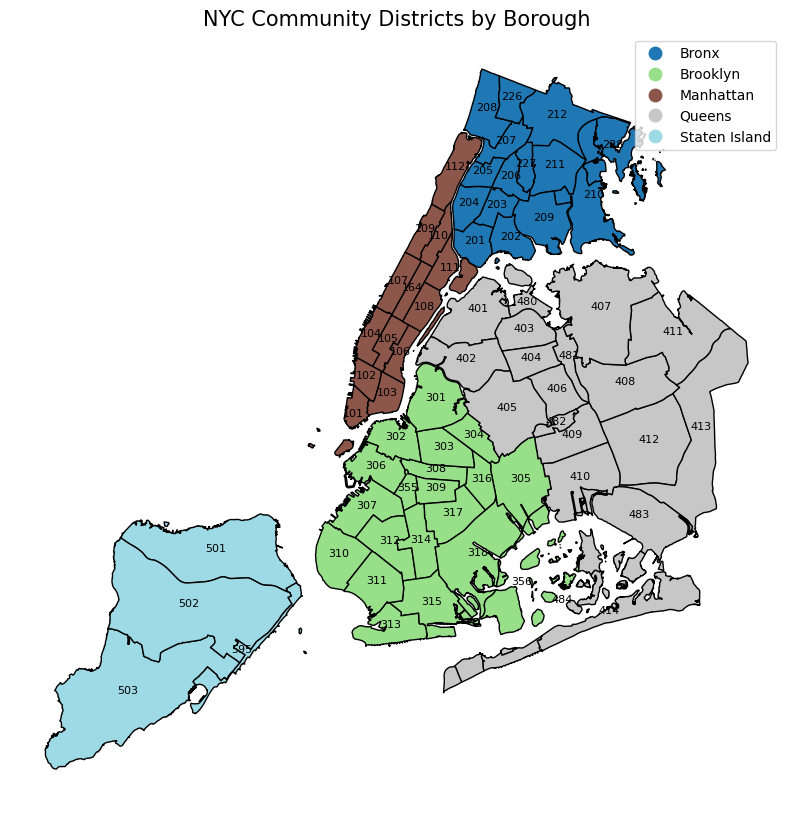

In [38]:
fig, ax = plt.subplots(figsize=(10, 10))

districts_gdf.plot(ax=ax, column='BOROUGH', legend=True, cmap='tab20', edgecolor='black')

for idx, row in districts_gdf.iterrows():
    plt.text(row.geometry.centroid.x, row.geometry.centroid.y,
             row['boro_cd'], fontsize=8, ha='center', color='black')

ax.set_title('NYC Community Districts by Borough', fontsize=15)
ax.axis('off')

plt.show()


##  Transforming DataFrames into a GeoDataFrame with geospatial capabilities.
 By doing this:
  - The dataset can now handle geospatial operations like spatial joins, distance calculations, or plotting on maps.
  - The geometry of each record is correctly formatted and accessible for GIS-related analysis.


### Shooting:

In [11]:
shooting_df['geometry'] = shooting_df['geocoded_column'].apply(loads)

shooting_gdf = gpd.GeoDataFrame(
    shooting_df,
    geometry='geometry',
    crs="EPSG:4326"  # Assuming WGS84 latitude/longitude
)


shooting_gdf = gpd.sjoin(shooting_gdf, districts_gdf[['geometry', 'boro_cd']], how='left', predicate='within')
shooting_gdf = shooting_gdf[['statistical_murder_flag', 'geometry', 'boro_cd']]
shooting_gdf.head()


,statistical_murder_flag,geometry,boro_cd
0,N,POINT (-73.76493 40.59922),414
1,N,POINT (-73.8147 40.73569),408
2,Y,POINT (-73.95966 40.67101),309
3,N,POINT (-73.91898 40.82847),204
4,Y,POINT (-73.98353 40.72605),103


### Crime:

In [12]:

complaint_df['geometry'] = complaint_df['New Georeferenced Column'].apply(loads)

crime_gdf = gpd.GeoDataFrame(
    complaint_df,
    geometry='geometry',
    crs="EPSG:4326"  # Assuming WGS84 latitude/longitude
)

crime_gdf = gpd.sjoin(crime_gdf, districts_gdf[['geometry', 'boro_cd']], how='left', predicate='within')
crime_gdf = crime_gdf[['LAW_CAT_CD', 'geometry', 'boro_cd']]
crime_gdf.head()


,LAW_CAT_CD,geometry,boro_cd
0,FELONY,POINT (-73.84727 40.88731),212
1,VIOLATION,POINT (-74.17854 40.55948),503
2,FELONY,POINT (-74.12361 40.63404),501
3,MISDEMEANOR,POINT (-74.21399 40.53685),503
4,FELONY,POINT (-74.21674 40.54256),503


### POI:

In [13]:
poi_df['geometry'] = poi_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

poi_gdf = gpd.GeoDataFrame(
    poi_df,
    geometry='geometry',
    crs="EPSG:4326"  # Assuming WGS84 latitude/longitude
)

columns_to_keep = [
    'boro_cd',
    'Residential',
    'Education Facility',
    'Cultural Facility',
    'Recreational Facility',
    'Social Services',
    'Transportation Facility',
    'Commercial',
    'Government Facility',
    'Religious Institution',
    'Health Services',
    'Public Safety',
    'Water',
    'Miscellaneous',
    'geometry'
]

poi_gdf = gpd.sjoin(poi_gdf, districts_gdf[['geometry', 'boro_cd']], how='left', predicate='within')
poi_gdf = poi_gdf[columns_to_keep]
poi_gdf.head()

,boro_cd,Residential,Education Facility,Cultural Facility,Recreational Facility,Social Services,Transportation Facility,Commercial,Government Facility,Religious Institution,Health Services,Public Safety,Water,Miscellaneous,geometry
0,102,0,0,0,0,0,1,0,0,0,0,0,0,0,POINT (-74.00702 40.72463)
1,407,0,0,0,0,0,1,0,0,0,0,0,0,0,POINT (-73.82662 40.79718)
2,302,0,0,0,0,0,1,0,0,0,0,0,0,0,POINT (-73.99395 40.70385)
3,103,0,0,0,0,0,1,0,0,0,0,0,0,0,POINT (-73.99194 40.7096)
4,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,POINT (-73.95266 40.73907)


### Airbnb:

In [30]:

uniqueID_airbnb['geometry'] = airbnb_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

uniqueID_airbnb = gpd.GeoDataFrame(
    uniqueID_airbnb,
    geometry='geometry',
    crs="EPSG:4326"  # Assuming WGS84 latitude/longitude
)

columns_to_keep = ['id','room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'number_of_reviews', 'review_scores_rating','geometry']

uniqueID_airbnb = uniqueID_airbnb[columns_to_keep]

## Creating Binary Indicator Features

We create binary indicator features to simplify the aggregation and analysis process. By converting categorical data (e.g., crime types or shooting outcomes) into numeric columns, we can:

- Easily count the occurrences of specific categories (e.g., felonies, violations, fatal shootings) during spatial joins or group-by operations.
- Generate meaningful and distinct statistics for each Airbnb location based on the surrounding data.
- Streamline the feature extraction process for further analysis or modeling.

This approach ensures a structured and efficient way to handle categorical information in geospatial datasets.


### Crime:
To gain a quick overview of the numbers and distributions in the dataset, we visualize key statistics

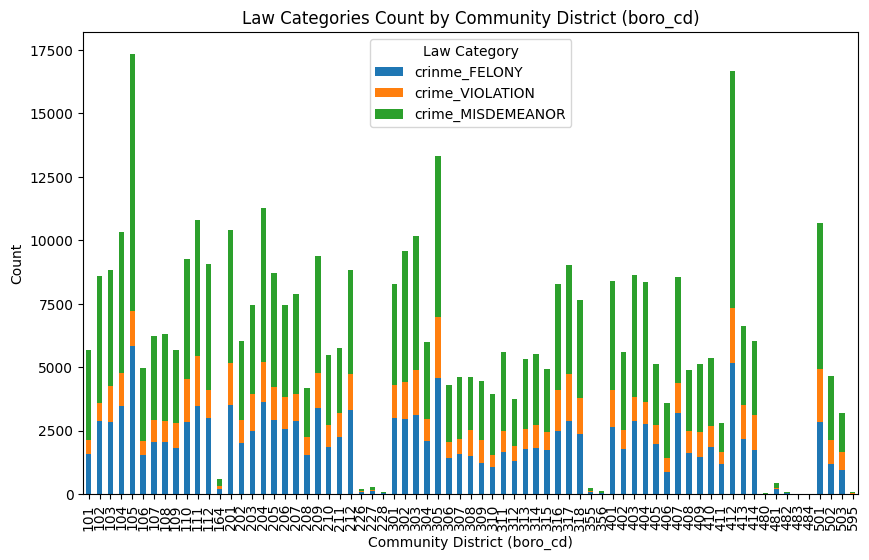

In [15]:

crime_gdf['crinme_FELONY'] = (crime_gdf['LAW_CAT_CD'] == 'FELONY').astype(int)
crime_gdf['crime_VIOLATION'] = (crime_gdf['LAW_CAT_CD'] == 'VIOLATION').astype(int)
crime_gdf['crime_MISDEMEANOR'] = (crime_gdf['LAW_CAT_CD'] == 'MISDEMEANOR').astype(int)

aggregated_crime = crime_gdf.groupby('boro_cd')[['crinme_FELONY', 'crime_VIOLATION', 'crime_MISDEMEANOR']].sum().reset_index()
aggregated_crime.set_index('boro_cd').plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title('Law Categories Count by Community District (boro_cd)')
plt.xlabel('Community District (boro_cd)')
plt.ylabel('Count')
plt.legend(title='Law Category')
plt.show()


### Shooting:
To gain a quick overview of the numbers and distributions in the dataset, we visualize key statistics

<Axes: xlabel='boro_cd'>

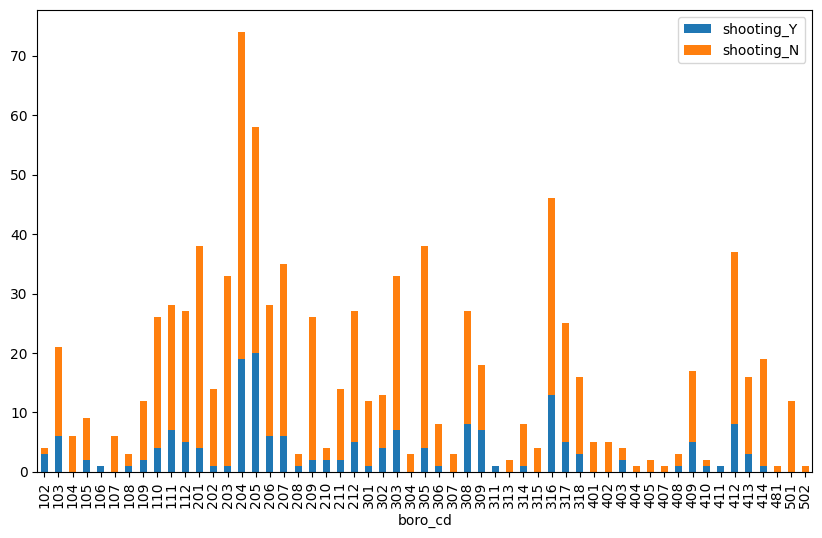

In [ ]:
shooting_gdf['shooting_Y'] = (shooting_gdf['statistical_murder_flag'] == 'Y').astype(int)
shooting_gdf['shooting_N'] = (shooting_gdf['statistical_murder_flag'] == 'N').astype(int)

aggregated_shooting = shooting_gdf.groupby('boro_cd')[['shooting_Y', 'shooting_N']].sum().reset_index()
aggregated_shooting.set_index('boro_cd').plot(kind='bar', stacked=True, figsize=(10, 6))

## Aggregation Approach

- **Why Not Aggregate by Boroughs?**  
  Aggregating Airbnb data by boroughs would result in all Airbnb entries within the same borough having identical feature sets. This limits the granularity of the analysis and the ability to capture localized variations within the city.

- **Our Solution: Buffer-Based Aggregation**  
  Instead of aggregating by borough or community district, we use **buffer zones** around each Airbnb location. This approach allows us to extract features specific to the immediate surroundings of each listing, ensuring that each Airbnb entry has unique, localized statistics. This method enables us to preserve spatial nuances and avoids over-generalization.

By adopting this buffer-based aggregation method, we create a geospatially enriched dataset that better reflects the diversity and complexity of NYC's neighborhoods and their impact on Airbnb listings.

In [31]:
uniqueID_airbnb.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 26270 entries, 0 to 26269
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   id                    26270 non-null  int64   
 1   room_type             26270 non-null  object  
 2   accommodates          26270 non-null  int64   
 3   bathrooms             26270 non-null  int64   
 4   bedrooms              26270 non-null  float64 
 5   beds                  26270 non-null  float64 
 6   price                 26270 non-null  float64 
 7   number_of_reviews     26270 non-null  int64   
 8   review_scores_rating  26270 non-null  float64 
 9   geometry              26270 non-null  geometry
dtypes: float64(4), geometry(1), int64(4), object(1)
memory usage: 2.0+ MB


### Explanation of Code Steps
 1. All datasets are transformed to the same coordinate reference system (CRS), EPSG:3857 (Web Mercator)
      -  This ensures consistency for geospatial operations like spatial joins or buffering, as differing CRSs can cause errors.
 2. Simplifies the geometry of features (e.g., shapes, polygons) to reduce computational complexity without losing essential spatial information.
    - This is useful for faster processing during spatial joins and visualizations
 3. Creates a buffer zone of 3000 meters around each Airbnb location. The buffer defines the area of interest for aggregating nearby features (e.g., crimes, POIs).
      - Updates the geometry column to use the buffer for subsequent spatial operations.

In [32]:

uniqueID_airbnb = uniqueID_airbnb.to_crs(epsg=3857)
shooting_gdf = shooting_gdf.to_crs(epsg=3857)
crime_gdf = crime_gdf.to_crs(epsg=3857)
poi_gdf = poi_gdf.to_crs(epsg=3857)

shooting_gdf = shooting_gdf[['statistical_murder_flag', 'geometry']]
crime_gdf = crime_gdf[['LAW_CAT_CD', 'geometry']]
poi_gdf = poi_gdf.drop(columns=['boro_cd'], errors='ignore')  # Keep all necessary POI columns


In [33]:
crime_gdf['geometry'] = crime_gdf.geometry.simplify(tolerance=10)
uniqueID_airbnb['geometry'] = uniqueID_airbnb.geometry.simplify(tolerance=10)

In [34]:
uniqueID_airbnb['buffer'] = uniqueID_airbnb.geometry.buffer(3000)
uniqueID_airbnb = uniqueID_airbnb.set_geometry('buffer')

### Perform spatial join with shootings

In [35]:
shooting_nearby = gpd.sjoin(shooting_gdf, uniqueID_airbnb, predicate='within')

shooting_agg = shooting_nearby.groupby('id', as_index=False).agg(
    shooting_count=('statistical_murder_flag', 'count'),
    murder_count=('statistical_murder_flag', lambda x: (x == 'Y').sum())
)


In [36]:
shooting_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25719 entries, 0 to 25718
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              25719 non-null  int64
 1   shooting_count  25719 non-null  int64
 2   murder_count    25719 non-null  int64
dtypes: int64(3)
memory usage: 602.9 KB


### Performing Spatial Join with the Crime Dataset

Given the computational expense of spatial joins and the large size of the datasets (over 26,000 Airbnb entries and more than 430,000 crime entries), the process is streamlined by dividing the data into chunks. This approach ensures efficient memory usage and prevents buffer overflow by processing smaller subsets of data and clearing memory after each iteration.
The process will be saved in an extern csv file.


In [127]:
# import gc  # For garbage collection

# chunk_size = 5000
# crime_chunks = [crime_gdf.iloc[i:i + chunk_size] for i in range(0, len(crime_gdf), chunk_size)]

# # Open a file to write results incrementally
# with open('crime_aggregated_resultsUNIQUE.csv', 'w') as result_file:
#     # Process each chunk
#     for i, chunk in enumerate(crime_chunks):
#         print(f"Processing chunk {i + 1} of {len(crime_chunks)}")
        
#         # Perform spatial join
#         crime_nearby = gpd.sjoin(chunk, uniqueID_airbnb, predicate='within')
        
#         # Ensure 'id' column is available
#         if 'id' not in crime_nearby.columns:
#             crime_nearby = crime_nearby.merge(uniqueID_airbnb[['id']], left_index=True, right_index=True, how='left')
        
#         # Aggregate crime data
#         crime_agg = crime_nearby.groupby('id').agg(
#             felony_count=('LAW_CAT_CD', lambda x: (x == 'FELONY').sum()),
#             misdemeanor_count=('LAW_CAT_CD', lambda x: (x == 'MISDEMEANOR').sum()),
#             violation_count=('LAW_CAT_CD', lambda x: (x == 'VIOLATION').sum())
#         )
        
#         # Save the chunk to the CSV incrementally
#         crime_agg.to_csv(result_file, header=(i == 0), mode='a')  # Write header only for the first chunk
        
#         # Clean up memory
#         del crime_nearby, crime_agg
#         gc.collect()  # Trigger garbage collection explicitly


Processing chunk 1 of 87
Processing chunk 2 of 87
Processing chunk 3 of 87
Processing chunk 4 of 87
Processing chunk 5 of 87
Processing chunk 6 of 87
Processing chunk 7 of 87
Processing chunk 8 of 87
Processing chunk 9 of 87
Processing chunk 10 of 87
Processing chunk 11 of 87
Processing chunk 12 of 87
Processing chunk 13 of 87
Processing chunk 14 of 87
Processing chunk 15 of 87
Processing chunk 16 of 87
Processing chunk 17 of 87
Processing chunk 18 of 87
Processing chunk 19 of 87
Processing chunk 20 of 87
Processing chunk 21 of 87
Processing chunk 22 of 87
Processing chunk 23 of 87
Processing chunk 24 of 87
Processing chunk 25 of 87
Processing chunk 26 of 87
Processing chunk 27 of 87
Processing chunk 28 of 87
Processing chunk 29 of 87
Processing chunk 30 of 87
Processing chunk 31 of 87
Processing chunk 32 of 87
Processing chunk 33 of 87
Processing chunk 34 of 87
Processing chunk 35 of 87
Processing chunk 36 of 87
Processing chunk 37 of 87
Processing chunk 38 of 87
Processing chunk 39 o

### Performing Spatial Join with the POI Dataset

The same here.

In [128]:

# columns_to_keep = [
    
#     'Residential',
#     'Education Facility',
#     'Cultural Facility',
#     'Recreational Facility',
#     'Social Services',
#     'Transportation Facility',
#     'Commercial',
#     'Government Facility',
#     'Religious Institution',
#     'Health Services',
#     'Public Safety',
#     'Water',
#     'Miscellaneous',
#     'geometry'
# ]

# # Filter the dataset to keep only the specified columns
# poi_gdf = poi_gdf[columns_to_keep]
# poi_gdf['geometry'] = poi_gdf.geometry.simplify(tolerance=10)

# chunk_size = 400
# poi_chunks = [poi_gdf.iloc[i:i + chunk_size] for i in range(0, len(poi_gdf), chunk_size)]

# # Open a file to write results incrementally
# with open('poi_aggregated_resultsUNIQUE.csv', 'w') as result_file:
#     # Process each chunk
#     for i, chunk in enumerate(poi_chunks):
#         print(f"Processing chunk {i + 1} of {len(poi_chunks)}")
        
#         # Perform spatial join with airbnb dataset (within a 3000-meter radius)
#         # Use buffer(3000) to create a radius around the Airbnb geometry
#         uniqueID_airbnb['buffered_geometry'] = uniqueID_airbnb.geometry.buffer(3000)
#         crime_nearby = gpd.sjoin(
#             chunk,
#             uniqueID_airbnb.set_geometry('buffered_geometry'),  # Use buffered geometry
#             predicate='within'
#         )
        
#         # Ensure 'id' column is available
#         if 'id' not in crime_nearby.columns:
#             crime_nearby = crime_nearby.merge(
#                 uniqueID_airbnb[['id']], left_index=True, right_index=True, how='left'
#             )
        
#         # Aggregate POI features within the radius
#         poi_agg = crime_nearby.groupby('id').agg({
#             'Residential': 'sum',
#             'Education Facility': 'sum',
#             'Cultural Facility': 'sum',
#             'Recreational Facility': 'sum',
#             'Social Services': 'sum',
#             'Transportation Facility': 'sum',
#             'Commercial': 'sum',
#             'Government Facility': 'sum',
#             'Religious Institution': 'sum',
#             'Health Services': 'sum',
#             'Public Safety': 'sum',
#             'Water': 'sum',
#             'Miscellaneous': 'sum',
#         })
        
#         # Save the chunk to the CSV incrementally
#         poi_agg.to_csv(result_file, header=(i == 0), mode='a')  # Write header only for the first chunk
        
#         # Clean up memory
#         del crime_nearby, poi_agg
#         gc.collect()  # Trigger garbage collection explicitly

# print("Processing completed.")


Processing chunk 1 of 51
Processing chunk 2 of 51
Processing chunk 3 of 51
Processing chunk 4 of 51
Processing chunk 5 of 51
Processing chunk 6 of 51
Processing chunk 7 of 51
Processing chunk 8 of 51
Processing chunk 9 of 51
Processing chunk 10 of 51
Processing chunk 11 of 51
Processing chunk 12 of 51
Processing chunk 13 of 51
Processing chunk 14 of 51
Processing chunk 15 of 51
Processing chunk 16 of 51
Processing chunk 17 of 51
Processing chunk 18 of 51
Processing chunk 19 of 51
Processing chunk 20 of 51
Processing chunk 21 of 51
Processing chunk 22 of 51
Processing chunk 23 of 51
Processing chunk 24 of 51
Processing chunk 25 of 51
Processing chunk 26 of 51
Processing chunk 27 of 51
Processing chunk 28 of 51
Processing chunk 29 of 51
Processing chunk 30 of 51
Processing chunk 31 of 51
Processing chunk 32 of 51
Processing chunk 33 of 51
Processing chunk 34 of 51
Processing chunk 35 of 51
Processing chunk 36 of 51
Processing chunk 37 of 51
Processing chunk 38 of 51
Processing chunk 39 o

### Loading Data from Geospatially Aggregated CSV Files


In [112]:
df_crime_aggreggated = pd.read_csv('crime_aggregated_resultsUNIQUE.csv')
df_crime_aggreggated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 635060 entries, 0 to 635059
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   id                 635060 non-null  int64
 1   felony_count       635060 non-null  int64
 2   misdemeanor_count  635060 non-null  int64
 3   violation_count    635060 non-null  int64
dtypes: int64(4)
memory usage: 19.4 MB


In [113]:
df_poi_aggreggated = pd.read_csv('poi_aggregated_resultsUNIQUE.csv')
df_poi_aggreggated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1335043 entries, 0 to 1335042
Data columns (total 14 columns):
 #   Column                   Non-Null Count    Dtype
---  ------                   --------------    -----
 0   id                       1335043 non-null  int64
 1   Residential              1335043 non-null  int64
 2   Education Facility       1335043 non-null  int64
 3   Cultural Facility        1335043 non-null  int64
 4   Recreational Facility    1335043 non-null  int64
 5   Social Services          1335043 non-null  int64
 6   Transportation Facility  1335043 non-null  int64
 7   Commercial               1335043 non-null  int64
 8   Government Facility      1335043 non-null  int64
 9   Religious Institution    1335043 non-null  int64
 10  Health Services          1335043 non-null  int64
 11  Public Safety            1335043 non-null  int64
 12  Water                    1335043 non-null  int64
 13  Miscellaneous            1335043 non-null  int64
dtypes: int64(14)
memor

### Aggregating Dataframes into Unique IDs and 

To avoid memory overflow, the aggregation process was divided into multiple tasks, resulting in dataframes with multiple entries for the same IDs. Now, we need to merge these entries to consolidate the data into unique IDs.


In [115]:
df_crime_aggreggated = df_crime_aggreggated.groupby('id', as_index=False).sum()
df_crime_aggreggated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26270 entries, 0 to 26269
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   id                 26270 non-null  int64
 1   felony_count       26270 non-null  int64
 2   misdemeanor_count  26270 non-null  int64
 3   violation_count    26270 non-null  int64
dtypes: int64(4)
memory usage: 821.1 KB


In [114]:
df_poi_aggreggated = df_poi_aggreggated.groupby('id', as_index=False).sum()
df_poi_aggreggated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26270 entries, 0 to 26269
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   id                       26270 non-null  int64
 1   Residential              26270 non-null  int64
 2   Education Facility       26270 non-null  int64
 3   Cultural Facility        26270 non-null  int64
 4   Recreational Facility    26270 non-null  int64
 5   Social Services          26270 non-null  int64
 6   Transportation Facility  26270 non-null  int64
 7   Commercial               26270 non-null  int64
 8   Government Facility      26270 non-null  int64
 9   Religious Institution    26270 non-null  int64
 10  Health Services          26270 non-null  int64
 11  Public Safety            26270 non-null  int64
 12  Water                    26270 non-null  int64
 13  Miscellaneous            26270 non-null  int64
dtypes: int64(14)
memory usage: 2.8 MB


### Merging Crime and Shooting Data on ID

The crime and shooting datasets are merged using an outer join on the `id` column. This ensures that all Airbnb entries are retained, even if some do not have corresponding shooting statistics.


In [135]:
merged_cime_shooting_airbnb = df_crime_aggreggated.merge(shooting_agg, on='id', how='outer')
merged_cime_shooting_airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26270 entries, 0 to 26269
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 26270 non-null  int64  
 1   felony_count       26270 non-null  int64  
 2   misdemeanor_count  26270 non-null  int64  
 3   violation_count    26270 non-null  int64  
 4   shooting_count     25668 non-null  float64
 5   murder_count       25668 non-null  float64
dtypes: float64(2), int64(4)
memory usage: 1.2 MB


### Merging Crime, Shooting and POI

In [136]:
final = merged_cime_shooting_airbnb.merge(df_poi_aggreggated, on='id', how='outer')
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26270 entries, 0 to 26269
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       26270 non-null  int64  
 1   felony_count             26270 non-null  int64  
 2   misdemeanor_count        26270 non-null  int64  
 3   violation_count          26270 non-null  int64  
 4   shooting_count           25668 non-null  float64
 5   murder_count             25668 non-null  float64
 6   Residential              26270 non-null  int64  
 7   Education Facility       26270 non-null  int64  
 8   Cultural Facility        26270 non-null  int64  
 9   Recreational Facility    26270 non-null  int64  
 10  Social Services          26270 non-null  int64  
 11  Transportation Facility  26270 non-null  int64  
 12  Commercial               26270 non-null  int64  
 13  Government Facility      26270 non-null  int64  
 14  Religious Institution 

### Final Merge: Combining All Data with the Airbnb Dataset

In this step, all aggregated features (crime, shooting, and points of interest) are merged with the Airbnb dataset. This final merge ensures that each Airbnb listing has a complete set of geospatially enriched features for analysis.



In [137]:
final = final.merge(uniqueID_airbnb, on='id', how='outer')
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26270 entries, 0 to 26269
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   id                       26270 non-null  int64   
 1   felony_count             26270 non-null  int64   
 2   misdemeanor_count        26270 non-null  int64   
 3   violation_count          26270 non-null  int64   
 4   shooting_count           25668 non-null  float64 
 5   murder_count             25668 non-null  float64 
 6   Residential              26270 non-null  int64   
 7   Education Facility       26270 non-null  int64   
 8   Cultural Facility        26270 non-null  int64   
 9   Recreational Facility    26270 non-null  int64   
 10  Social Services          26270 non-null  int64   
 11  Transportation Facility  26270 non-null  int64   
 12  Commercial               26270 non-null  int64   
 13  Government Facility      26270 non-null  int64   
 14  Religi

In [138]:
final.to_csv('../../data/final/final.csv', index=False)